In [1]:
import os
import pandas as pd
import xgboost
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pickle
# plt.style.use('dark_background')

## Load Data

To ensure no matter who uses this notebook, they will have the data available to run this notebook, we are downloading a local copy into the local Notebook file system if it is not already there.

In [2]:
if not os.path.exists('./home/full_joined_data.csv'):
    data_csv_itm = gis.content.get('43b00dead86041daa3a5c78aadf2911c')
    data_csv_itm.download('./home')
    
df = pd.read_csv('./home/full_joined_data.csv', index_col=0)
df.head()

,origin_id,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,proximity_minutes_03,...,schoolenrollment_acsgrd9,schoolenrollment_acspubgrd9,schoolenrollment_acsprvgrd9,schoolenrollment_acscollege,schoolenrollment_acspubcoll,schoolenrollment_acsprvcoll,schoolenrollment_acsgrad,schoolenrollment_acspubgrad,schoolenrollment_acsprvgrad,schoolenrollment_acsnotnsch
0,410050201001000,998326755,1.548381,3.355589,236771176,1.716985,3.834511,731023672,1.776342,3.778623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,410050201001001,998326755,1.358351,2.816526,236771176,1.526954,3.295449,731023672,1.586312,3.239560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,410050201001002,998326755,1.683183,3.781076,236771176,1.851786,4.259999,731023672,1.911143,4.204111,...,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,27.0
3,410050201001003,998326755,1.480122,3.140135,236771176,1.648726,3.619058,731023672,1.708083,3.563170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,410050201001004,998326755,1.577137,2.642447,236771176,1.745741,3.121370,731023672,1.805098,3.065482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


## Select Features

Since the table contains a few identifiers, notably `origin_id` and the fields starting with `destination_id_`, we exclude those columns to build our traning table. Also, while metrics for our second, third and fourth locations are included, we are not using those either, so we are excluding them as well.

In [3]:
feature_list = df.columns.tolist()
_ = feature_list.index('groupquarters_gqpop_cy')
enrichment_variables = feature_list[_:]
other_variables = [f for f in feature_list[:_] if '_id' not in f and 'trip_count' not in f]

In [4]:
print(enrichment_variables[:5])

['groupquarters_gqpop_cy', 'generations_genalphacy', 'generations_genz_cy', 'generations_millenn_cy', 'generations_genx_cy']


In [5]:
print(other_variables[:5])

['proximity_kilometers_01', 'proximity_minutes_01', 'proximity_kilometers_02', 'proximity_minutes_02', 'proximity_kilometers_03']


In [6]:
[var for var in other_variables if 'name_category' in var][:20]

['store_name_category_01_ALLEGRO_COFFEE',
 'store_name_category_01_AVA_ROASTERIA',
 'store_name_category_01_BELMONT_COFFEE_SVC',
 'store_name_category_01_BLACK_ROCK_COFFEE',
 'store_name_category_01_BLACK_ROCK_COFFEE_BAR',
 'store_name_category_01_BLACKROCK_COFFEE',
 'store_name_category_01_BLUE_MOON_COFFEE',
 'store_name_category_01_BREWED_AWAKENINGS_COFFEE_CO',
 'store_name_category_01_CITY_COFFEE',
 'store_name_category_01_COAVA_COFFEE_ROASTERS',
 'store_name_category_01_COFFEE_RUSH',
 'store_name_category_01_DUTCH_BROTHERS_COFFEE',
 'store_name_category_01_GAIA_JAVA',
 'store_name_category_01_HUMAN_BEAN',
 'store_name_category_01_INDEPENDENT',
 'store_name_category_01_INSOMNIA_COFFEE_CO',
 'store_name_category_01_JIM_PATTYS_COFFEE',
 'store_name_category_01_STARBUCKS',
 'store_name_category_01_STUMPTOWN_COFFEE_ROASTERS',
 'store_name_category_01_SYMPOSIUM_COFFEE']

In [7]:
# All feature columns
features = other_variables + enrichment_variables

## Data Exploration

Before jumping directly into building a model, we need to better understand the data, understand what we are working with and what is then possible to do with this data.

In [8]:
# Pearson correlation between variables
from scipy.stats import pearsonr
R = np.array([pearsonr(df.loc[:,'trip_count_01'] ,df.loc[:,c])[0] for c in enrichment_variables])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [9]:
idx = np.argsort(R)
print(np.sort(R)[::-1][:50])

[       nan 0.22442656 0.22439592 0.21920774 0.21888378 0.21656343
 0.21541961 0.21426458 0.21188184 0.20815804 0.20502082 0.20451242
 0.20244597 0.20115134 0.19982251 0.19880778 0.1973394  0.19732674
 0.19684522 0.19677372 0.19627985 0.19478658 0.19478658 0.19211093
 0.19191782 0.19163585 0.19143629 0.19143629 0.19143629 0.19143629
 0.19140195 0.19138718 0.19089667 0.19072535 0.19053935 0.19007501
 0.19007501 0.18981339 0.18967893 0.18864798 0.18796019 0.18781586
 0.18678172 0.18599617 0.1857666  0.18574899 0.18551951 0.18518005
 0.18510752 0.18508931]


While we see a lot of correlations, none exceed roughly 22%. It will have to be a combination of factors to derive any reasonable preditive power.

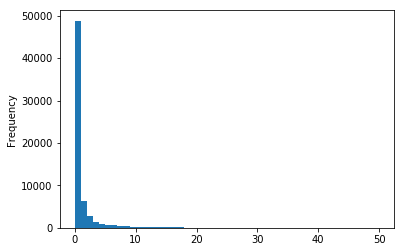

In [10]:
df.trip_count_01.plot.hist(range(51))

In [11]:
df.loc[:,'log_trip_count'] = np.log10(df.trip_count_01 + 1)

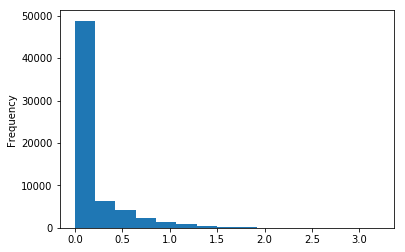

In [12]:
df.log_trip_count.plot.hist(15)

By far, the majority are zeros. Since most blocks DON'T visit a coffee shop, it makes sense to look at this initially as a binary classification problem.

_Will somebody residing in a block visit this coffee shop?_

In [13]:
df.trip_count_01.describe()

count    64930.000000
mean         1.455968
std          9.828946
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1616.000000
Name: trip_count_01, dtype: float64

In [14]:
df.trip_count_01.median()

0.0

The max is MUCH higher than the mean, and the median is zero. This further supports the first conclusion from the Peasons-R investigation - it makes _much_ more sense to use a binary classifier.

## Model Development

Based on the above conclusions, we have enough to create a binary classifier, which can be very useful for marketing decisions when opening a new location.

In [15]:
X = df.loc[:,features]

In [16]:
# Binary classification target
y_c = df.loc[:,'trip_count_01'].values > 0
# Log regression target
y_r = df.loc[:,'log_trip_count'].values 

In [17]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X.values, y_c, test_size=0.25, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X.values, y_r, test_size=0.25, random_state=42)

In [18]:
np.mean(y_train_c),np.mean(y_test_c)

(0.24794135162330327, 0.24893734984291258)

In [19]:
np.mean(y_train_r),np.mean(y_test_r)

(0.1497310153246085, 0.15149434815277438)

In [ ]:
xg_c = (
    xgboost.XGBClassifier(n_estimators=1000, learning_rate=0.1)
        .fit(
            X_train_c, 
            y_train_c, 
            eval_set=[(X_test_c,y_test_c)], 
            eval_metric='auc',
            early_stopping_rounds=20
        )
)

[0]	validation_0-auc:0.784607
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.797028
[2]	validation_0-auc:0.797982
[3]	validation_0-auc:0.798901
[4]	validation_0-auc:0.801496
[5]	validation_0-auc:0.803323
[6]	validation_0-auc:0.808703
[7]	validation_0-auc:0.809849
[8]	validation_0-auc:0.811574
[9]	validation_0-auc:0.812646
[10]	validation_0-auc:0.813046
[11]	validation_0-auc:0.813842
[12]	validation_0-auc:0.813751
[13]	validation_0-auc:0.81527
[14]	validation_0-auc:0.816138
[15]	validation_0-auc:0.817238
[16]	validation_0-auc:0.817612
[17]	validation_0-auc:0.819503
[18]	validation_0-auc:0.819638
[19]	validation_0-auc:0.820831
[20]	validation_0-auc:0.821351
[21]	validation_0-auc:0.821411
[22]	validation_0-auc:0.821617
[23]	validation_0-auc:0.822553
[24]	validation_0-auc:0.823758
[25]	validation_0-auc:0.824166
[26]	validation_0-auc:0.824844
[27]	validation_0-auc:0.82576
[28]	validation_0-auc:0.825935
[29]	validation_0-auc:0.826787
[30]	validation_0-

[259]	validation_0-auc:0.85036
[260]	validation_0-auc:0.850339
[261]	validation_0-auc:0.850383
[262]	validation_0-auc:0.850411
[263]	validation_0-auc:0.850464
[264]	validation_0-auc:0.85051
[265]	validation_0-auc:0.850608
[266]	validation_0-auc:0.850629
[267]	validation_0-auc:0.85081
[268]	validation_0-auc:0.850832
[269]	validation_0-auc:0.85086
[270]	validation_0-auc:0.850896
[271]	validation_0-auc:0.850899
[272]	validation_0-auc:0.850894
[273]	validation_0-auc:0.850878
[274]	validation_0-auc:0.850977
[275]	validation_0-auc:0.85101
[276]	validation_0-auc:0.851024
[277]	validation_0-auc:0.851035
[278]	validation_0-auc:0.851144
[279]	validation_0-auc:0.851127
[280]	validation_0-auc:0.851159
[281]	validation_0-auc:0.851191
[282]	validation_0-auc:0.851189
[283]	validation_0-auc:0.851216
[284]	validation_0-auc:0.851296
[285]	validation_0-auc:0.851292
[286]	validation_0-auc:0.851342
[287]	validation_0-auc:0.851367
[288]	validation_0-auc:0.851385
[289]	validation_0-auc:0.851397
[290]	validat

[516]	validation_0-auc:0.855138
[517]	validation_0-auc:0.855143
[518]	validation_0-auc:0.85514
[519]	validation_0-auc:0.855134
[520]	validation_0-auc:0.855146
[521]	validation_0-auc:0.855115
[522]	validation_0-auc:0.855173
[523]	validation_0-auc:0.855195
[524]	validation_0-auc:0.855195
[525]	validation_0-auc:0.855195
[526]	validation_0-auc:0.855195
[527]	validation_0-auc:0.855189
[528]	validation_0-auc:0.855192
[529]	validation_0-auc:0.855193
[530]	validation_0-auc:0.855199
[531]	validation_0-auc:0.855203
[532]	validation_0-auc:0.855217
[533]	validation_0-auc:0.855196
[534]	validation_0-auc:0.855169
[535]	validation_0-auc:0.85521
[536]	validation_0-auc:0.855188
[537]	validation_0-auc:0.855191
[538]	validation_0-auc:0.855187
[539]	validation_0-auc:0.855183
[540]	validation_0-auc:0.855192
[541]	validation_0-auc:0.855185
[542]	validation_0-auc:0.855191
[543]	validation_0-auc:0.855175
[544]	validation_0-auc:0.855172
[545]	validation_0-auc:0.855173
[546]	validation_0-auc:0.855205
[547]	vali

[773]	validation_0-auc:0.857533
[774]	validation_0-auc:0.857535
[775]	validation_0-auc:0.857551
[776]	validation_0-auc:0.857545
[777]	validation_0-auc:0.857539
[778]	validation_0-auc:0.85755
[779]	validation_0-auc:0.857539
[780]	validation_0-auc:0.85753
[781]	validation_0-auc:0.857516
[782]	validation_0-auc:0.857529
[783]	validation_0-auc:0.857531
[784]	validation_0-auc:0.857523


## Evaluation

Now, we run the model against the test as well as the train datasets to examine and visualize a few metrics describing the results.

In [22]:
# Classification probabilities
yp_test_c = xg_c.predict_proba(X_test_c)[:,1]
yp_train_c = xg_c.predict_proba(X_train_c)[:,1]

print("Accuracy (Train):", accuracy_score(y_train_c, yp_train_c > 0.5))
print("Accuracy (Test):", accuracy_score(y_test_c, yp_test_c > 0.5))
print("Precision (Train):", precision_score(y_train_c, yp_train_c > 0.5))
print("Precision (Test):", precision_score(y_test_c, yp_test_c > 0.5))
print("Recall (Train):", recall_score(y_train_c, yp_train_c > 0.5))
print("Recall (Test):", recall_score(y_test_c, yp_test_c > 0.5))
print("ROC AUC (Train)", roc_auc_score(y_train_c, yp_train_c))
print("ROC AUC (Test)", roc_auc_score(y_test_c, yp_test_c))

Accuracy (Train): 0.8520648089204674
Accuracy (Test): 0.8227068317624592
Precision (Train): 0.804375
Precision (Test): 0.7195167987919969
Recall (Train): 0.5329633924134504
Recall (Test): 0.471665429349171
ROC AUC (Train) 0.8930226656015525
ROC AUC (Test) 0.8575514180925046


In [23]:
prec_te,rec_te,thres = precision_recall_curve(y_test_c, yp_test_c)
prec_tr,rec_tr,thres = precision_recall_curve(y_train_c, yp_train_c)

In [24]:
fpr_te,tpr_te,thres = roc_curve(y_test_c, yp_test_c)
fpr_tr,tpr_tr,thres = roc_curve(y_train_c, yp_train_c)

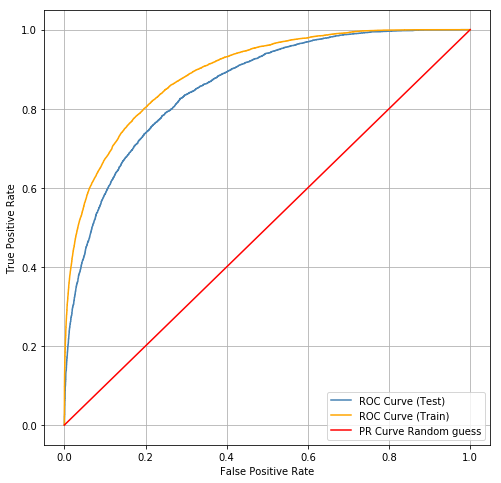

In [25]:
plt.figure(figsize=(8,8))
plt.plot(fpr_te,tpr_te,'-',color='steelblue', label="ROC Curve (Test)")
plt.plot(fpr_tr,tpr_tr,'-',color='orange', label="ROC Curve (Train)")
plt.plot([0,1],[0,1],'r-', label='PR Curve Random guess')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

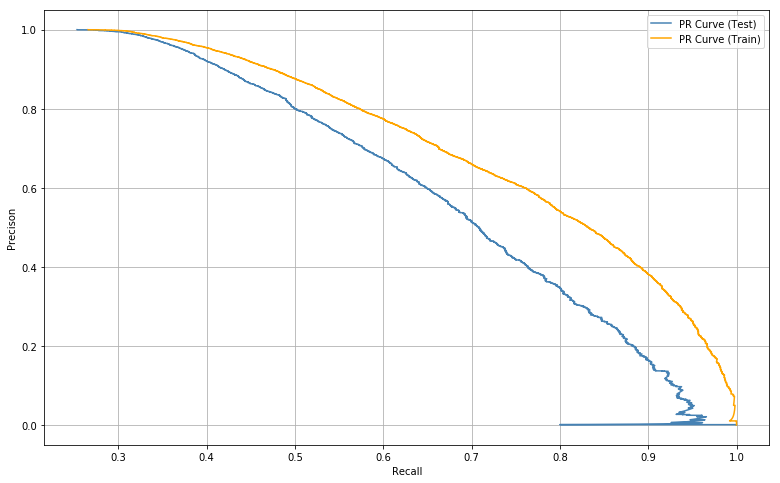

In [26]:
plt.figure(figsize=(13,8))
plt.plot(prec_te,rec_te,'-',color='steelblue', label="PR Curve (Test)")
plt.plot(prec_tr,rec_tr,'-',color='orange', label="PR Curve (Train)")
plt.ylabel('Precison')
plt.xlabel('Recall')
plt.grid()
plt.legend()
plt.show()

In [27]:
print(np.sum(xg_c.feature_importances_ > 0))

652


In [28]:
idx = np.argsort(xg_c.feature_importances_)

In [29]:
np.array(features)[idx][-50:]

array(['store_name_category_04_BLUE_MOON_COFFEE',
       'agebyracebysex_asnm45_cy', 'proximity_kilometers_03',
       'disposableincome_a65di25_cy', 'householdincome_avghinc_cy',
       'agebyracebysex_magebasecy', 'householdincome_hinc100_cy',
       'disposableincome_avgdia75cy', 'householdincome_hinc25_cy',
       'networth_a75nw150cy', 'store_name_category_03_HUMAN_BEAN',
       'networth_a65nw150cy', 'store_name_category_02_HUMAN_BEAN',
       'store_name_category_04_HUMAN_BEAN', 'disposableincome_aggdia75cy',
       'housingbysize_own4pers10', 'store_name_category_01_INDEPENDENT',
       'households_acsnopubai', 'householdtype_famhh10',
       'store_name_category_02_BLUE_MOON_COFFEE',
       'store_name_category_03_BLUE_MOON_COFFEE',
       'store_name_category_02_ALLEGRO_COFFEE',
       'store_name_category_03_UNCLE_GARYS_COFFEE_EMPORIUM',
       'store_name_category_02_GAIA_JAVA', 'housingcosts_acsaggvalm',
       'agebyracebysex_asnm10_cy', 'householdtype_pinlawfh10',
      

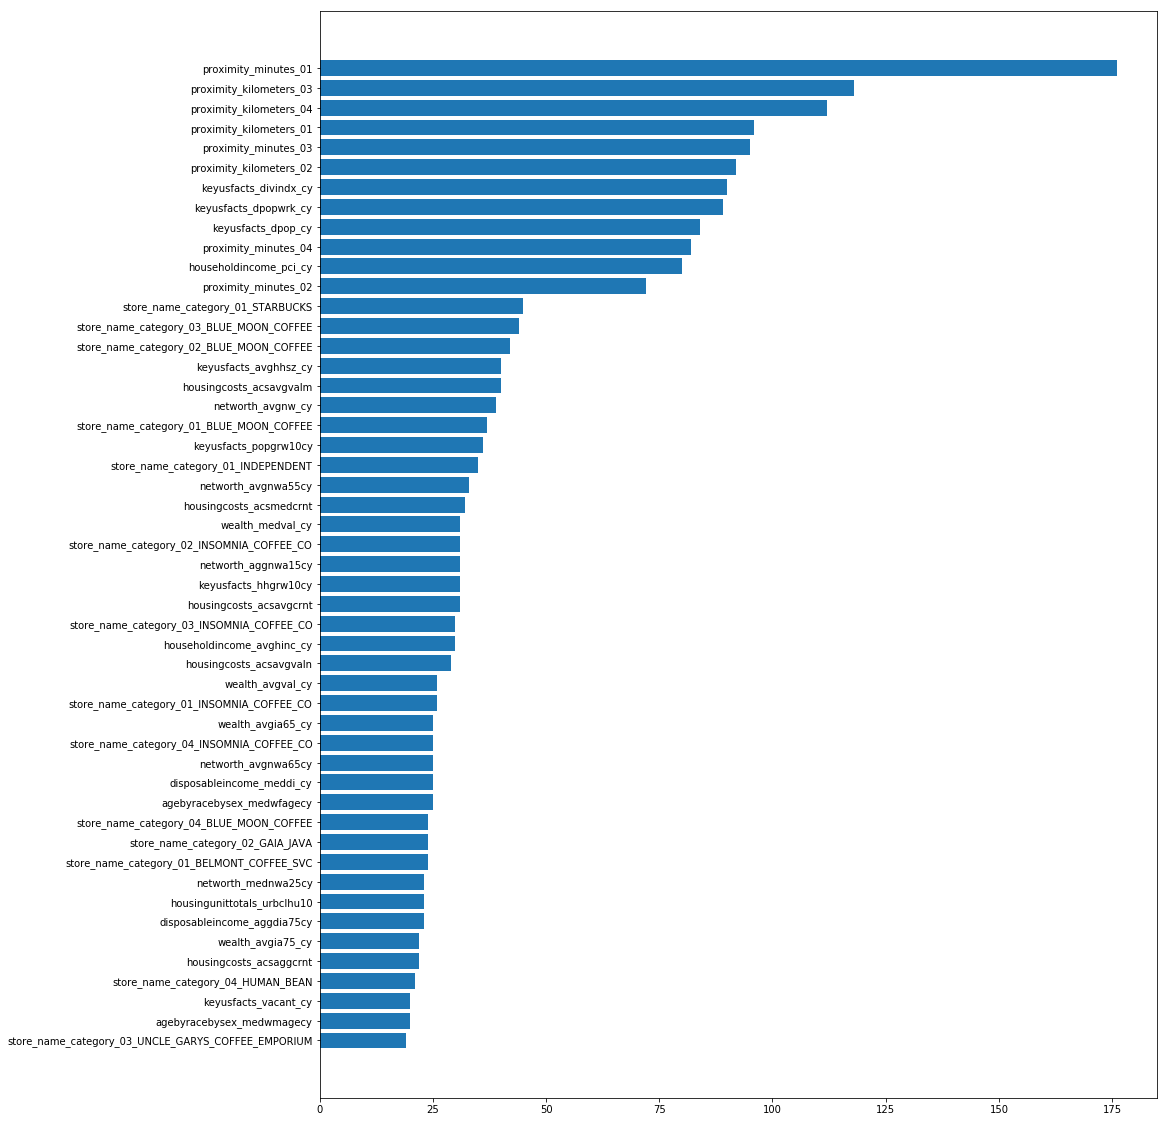

In [30]:
def plot_feature_importances(model, n_features=50, importance_type='weight'):
    feature_importances = model.get_booster().get_score(importance_type=importance_type)
    importance_values, feature_names = zip(
        *sorted(
            (v,features[int(k.split('f')[1])]) for k,v in feature_importances.items()
        )
    )
    
    plt.figure(figsize=(15,20))
    
    plt.barh(range(n_features), importance_values[-n_features:])
    _ =plt.yticks(range(50),feature_names[-n_features:])
#     plt.title(f"Feature Importance ({importance_type} importance)")

plot_feature_importances(xg_c, 50, 'weight')

In [35]:
pickle.dump(xg_c, open('./home/model_xg_c.pkl', 'wb'))

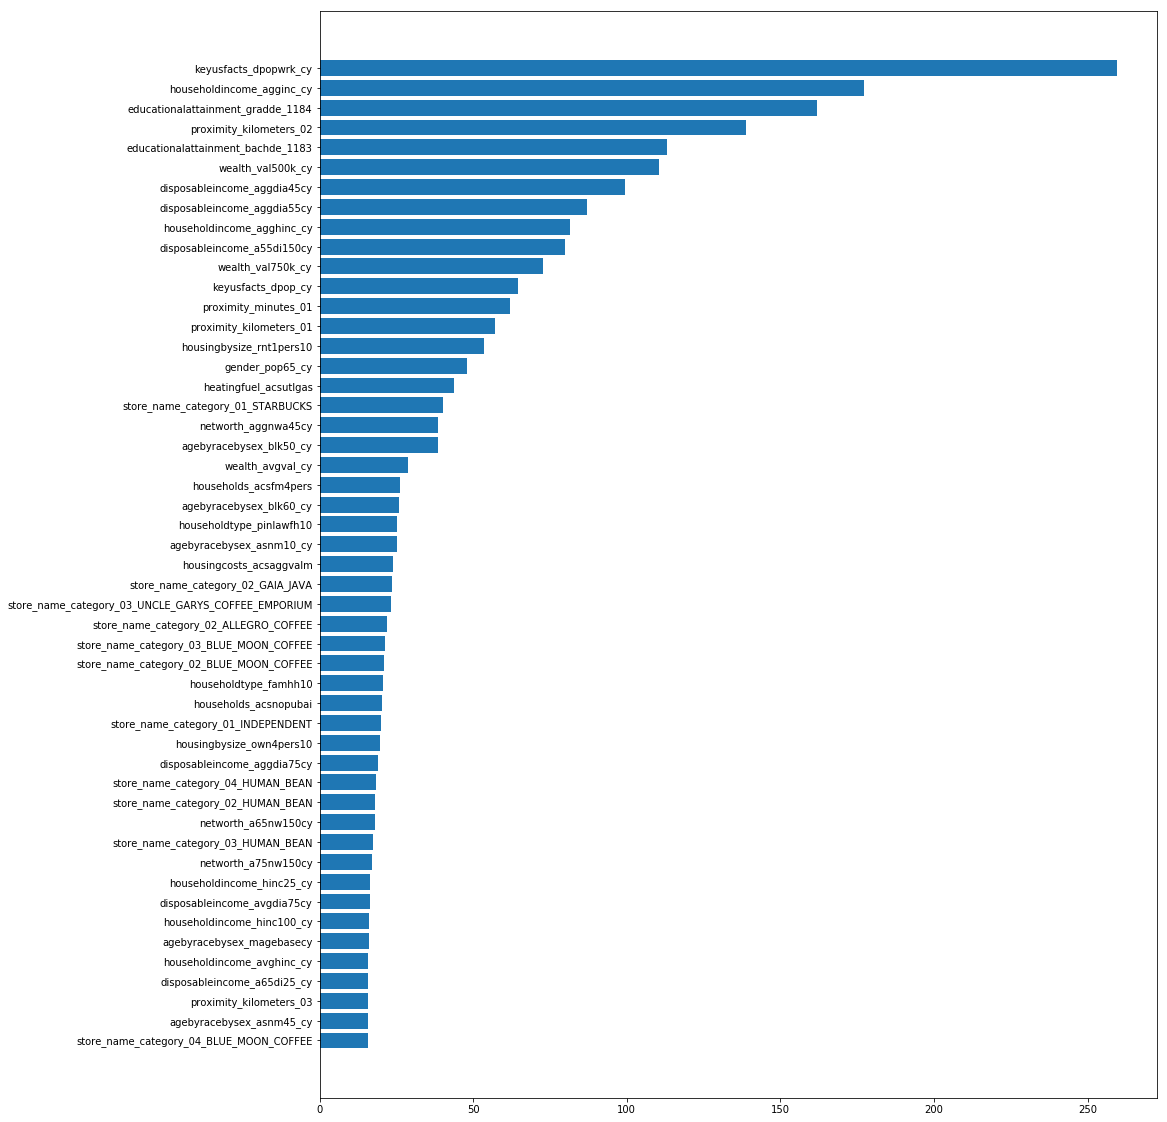

In [31]:
plot_feature_importances(xg_c, 50, 'gain')

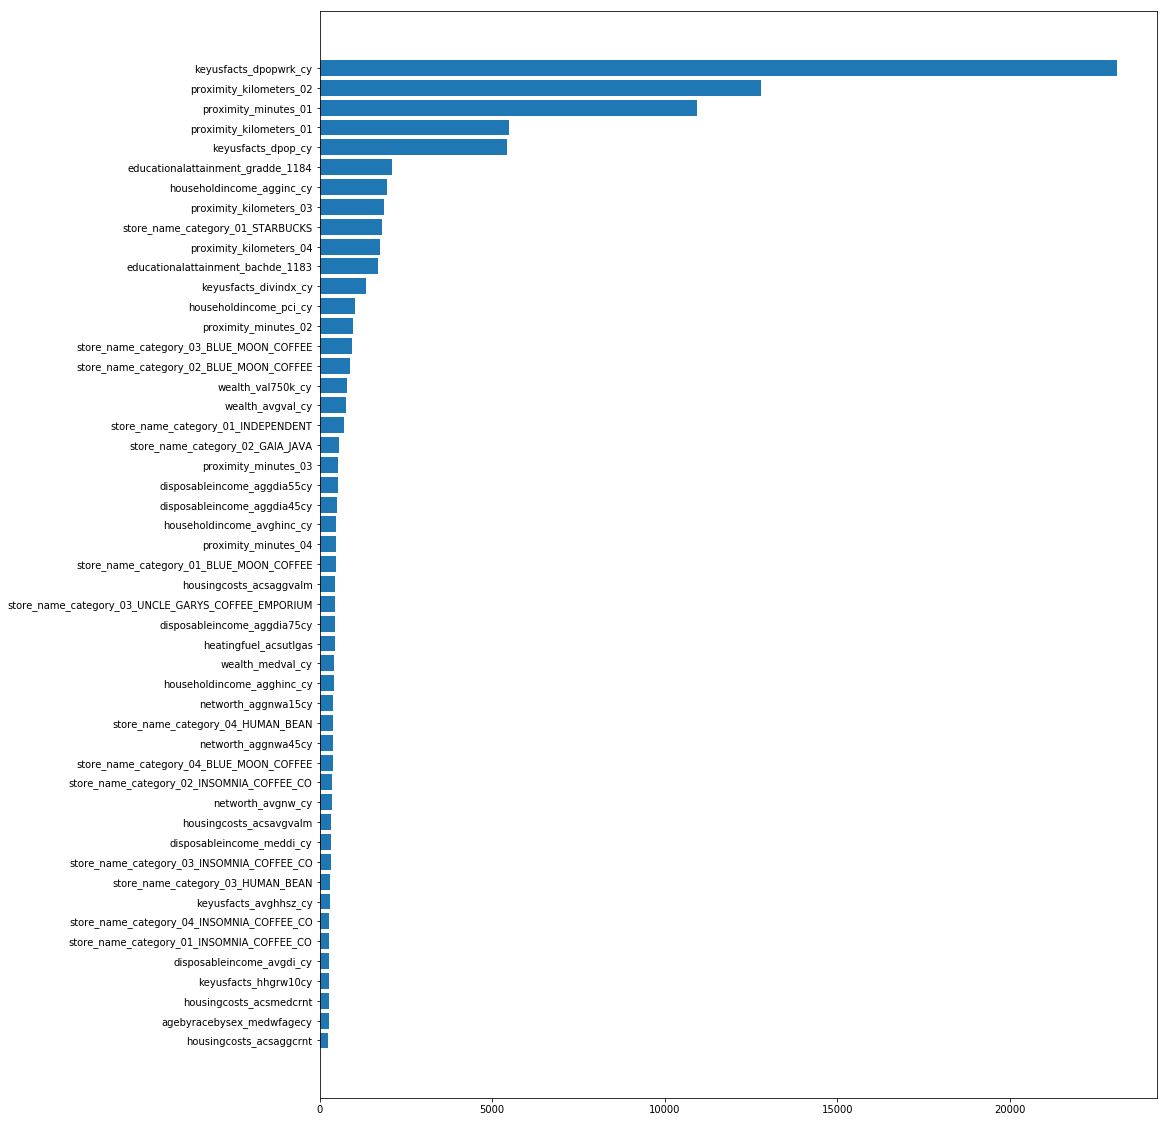

In [32]:
plot_feature_importances(xg_c, 50, 'total_gain')